In [1]:
import gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
lr = 0.01
gamma = 0.99
log_interval = 10

env = gym.make('Acrobot-v1')
env = env.unwrapped
N_actions = env.action_space.n
N_states = env.observation_space.shape[0]

C:\Users\K\Anaconda3\envs\tf\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [72]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.eps = None
        self.optimizer = None
        
        self.fc1 = nn.Linear(N_states, 256)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(256, 128)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(128, 32)
        self.fc3.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(32, N_actions)
        self.out.weight.data.normal_(0, 0.1)
        
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions_value = self.out(x)
        actions_policy = F.softmax(actions_value, dim = 1)
        return actions_policy
    
    def select_action(self, x):
        state = torch.from_numpy(x).float().view(-1,N_states)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    def finish_episode(self):
        G = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            G = r + gamma * G
            returns.insert(0, G)
        
        returns = torch.tensor(returns)
        returns = (returns -  returns.mean())/(returns.std() + self.eps)
        for log_prob, G in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * G)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.saved_log_probs[:]

In [103]:
def main():
    policy = Policy()
    policy.optimizer = optim.Adam(policy.parameters(), lr =lr)
    policy.eps = np.finfo(np.float32).eps.item()
    
    episode = []
    time = []
    re = []
    running_reward = 10
    for i_episode in range(200):
        state = env.reset()
        ep_reward = 0
        for t in range(1, 10000):
            env.render()
            action = policy.select_action(state)
            state, reward, done, info = env.step(action)
            
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
                
        episode.append(i_episode)
        
        #running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        #re.append(running_reward)  
        time.append(-1 * ep_reward)
        policy.finish_episode()
        if i_episode % log_interval ==0:
            print('Ep {}\t Elapsed time: {:.2f}'.format(
            i_episode, ep_reward))
    env.close()
    
    plt.title("Acrobot rewards")
    plt.plot(episode, time)
    plt.xlabel("episode")
    plt.ylabel("elapsed times")
    plt.show()            

Ep 0	 Elapsed time: -1029.00
Ep 10	 Elapsed time: -135.00
Ep 20	 Elapsed time: -310.00
Ep 30	 Elapsed time: -285.00
Ep 40	 Elapsed time: -230.00
Ep 50	 Elapsed time: -146.00
Ep 60	 Elapsed time: -131.00
Ep 70	 Elapsed time: -138.00
Ep 80	 Elapsed time: -157.00
Ep 90	 Elapsed time: -148.00
Ep 100	 Elapsed time: -152.00
Ep 110	 Elapsed time: -120.00
Ep 120	 Elapsed time: -1391.00
Ep 130	 Elapsed time: -199.00
Ep 140	 Elapsed time: -399.00
Ep 150	 Elapsed time: -290.00
Ep 160	 Elapsed time: -143.00
Ep 170	 Elapsed time: -446.00
Ep 180	 Elapsed time: -2486.00
Ep 190	 Elapsed time: -181.00


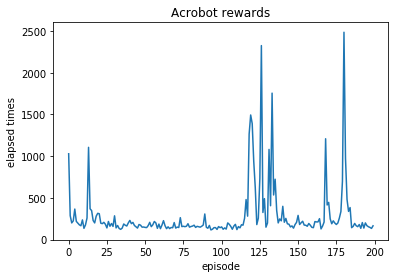

In [104]:
main()

In [62]:
action = c.sample()
action

tensor([2])

In [102]:
env.close()

In [71]:
c.log_prob(torch.from_numpy(np.array(1)))

tensor([-1.0712], grad_fn=<SqueezeBackward1>)

In [70]:
c.log_prob(action
          )

tensor([-1.1366], grad_fn=<SqueezeBackward1>)